## <center> Predicting AFL Match Attendances: an End-to-End Data Science Project
The aim of this project is to use machine learning algorithms to predict the attendances of AFL matches. There are 4 main stages to the project:
 - Data collection (from online sources)
 - Data preparation (cleaning and combining the 7 raw data files)
 - Feature engineering (creating new informative features from the data)
 - Building machine learning models (to make the actual predictions) 

In [1]:
#Import libraries
import pandas as pd
from datetime import timedelta
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Cleaning


First, I combined and clean the data about the date and time of the matches. 2 separate sources had to be used for this data as one didn't cover the whole 2004-2018 timespan and the other had lower quality data.

In [2]:
# Read in first data file and take a look. This file contains matches from 2004 to 2009.
time_data1 = pd.read_csv('date_and_time_data_1.csv')
time_data1.head()

,date_time,day,home_team,away_team,stadium
0,26/03/2004 19:45,Friday,Richmond,Collingwood,MCG
1,27/03/2004 14:15,Saturday,Hawthorn,Melbourne,MCG
2,27/03/2004 15:45,Saturday,Fremantle,Carlton,Subiaco
3,27/03/2004 19:15,Saturday,St Kilda,Geelong,Docklands
4,27/03/2004 19:15,Saturday,Brisbane Lions,Sydney,Gabba


The times in the time_data1.csv file are all AEST/AEDT so need to be converted to the local time. 

In [3]:
# Split date_time into 2 separate columns and convert to pd.Datetime type

time_data1[['date','time']] = time_data1.date_time.str.split(' ', n = 2, expand = True)
time_data1['date'] = pd.to_datetime(time_data1['date'], format = "%d/%m/%Y")
time_data1['time'] = pd.to_datetime(time_data1['time'], format = "%H:%M")

# Create dictionary to convert AEST to ACST or AWST where necessary. Entries: 'stadiumName':[# of hours behind, # of mins behind]
dict_of_stadium_and_n = {'Subiaco': [2,0], 'Footy Park': [0,30], 'Marrara': [0,30]}


#Function that takes a row and converts its time to LOCAL TIME
#NOTE: This doesn't take into daylight savings but no need to, since this won't affect the timeslot categorisations later on.

def take_n_hours(row):
    if row.stadium in dict_of_stadium_and_n.keys():
        new_time = row['time'] - timedelta(hours = dict_of_stadium_and_n[row.stadium][0], minutes = 
                                        dict_of_stadium_and_n[row.stadium][1])
    else:
        new_time = row['time']
    return new_time.time()

# Execute function on whole dataframe
time_data1['local_time'] = time_data1.apply(take_n_hours, axis=1)

# Remove time variable (we only need local time) and also drop date_time
time_data1.drop(['time', 'date_time'], axis = 1, inplace = True)

time_data1.head()

,day,home_team,away_team,stadium,date,local_time
0,Friday,Richmond,Collingwood,MCG,2004-03-26,19:45:00
1,Saturday,Hawthorn,Melbourne,MCG,2004-03-27,14:15:00
2,Saturday,Fremantle,Carlton,Subiaco,2004-03-27,13:45:00
3,Saturday,St Kilda,Geelong,Docklands,2004-03-27,19:15:00
4,Saturday,Brisbane Lions,Sydney,Gabba,2004-03-27,19:15:00


In [4]:
#Remove unecessary rows (the ones that are contained in time_data_2.csv)
time_data1 = time_data1[:1064]

#Sort rows by descending date/time
time_data1.sort_values(by=['date','local_time'], ascending = [False, False], inplace=True, na_position = 'first')

print(time_data1.shape)

(1064, 6)


Now the first dataset has been cleaned, we need to clean the second one and combine them.

In [5]:
# Read in data and take a look
time_data2 = pd.read_csv('date_and_time_data_2.csv', encoding='cp1252')
time_data2.head(3)

,date,local_time,h_team,a_team,venue
0,24-Mar-19,15:20,Fremantle,North Melbourne,Optus Stadium
1,24-Mar-19,15:20,GWS Giants,Essendon,Spotless Stadium
2,24-Mar-19,13:10,St Kilda,Gold Coast,Marvel Stadium


In [6]:
# Convert the date and local_time columns to pd.datetime objects

time_data2['date'] = pd.to_datetime(time_data2.date.str.upper(), format='%d-%b-%y', yearfirst=False)
time_data2['local_time'] = pd.to_datetime(time_data2['local_time'], format = "%H:%M").dt.time

# Make a new column for day of the week
time_data2['day'] = time_data2['date'].dt.weekday_name

#Rename and reorder the columns so that they match with those in the date_and_time_data1

time_data2 = time_data2[['day','h_team','a_team','venue','date','local_time']].copy() 
time_data2.rename(columns = {'h_team':'home_team','a_team':'away_team','venue':'stadium'}, inplace = True)

In [7]:
# Combine the dataframes (they have identical column names)
time_data_full = time_data2.append(time_data1, ignore_index=True) 

#Sort by date and time
time_data_full.sort_values(by=['date','local_time'], ascending = [False, False], inplace=True, na_position = 'first')

# Showing that the number of rows is the sum of the 2 component dataframes.

print("#1:" + str(time_data1.shape))
print("#2:" + str(time_data2.shape))
print("Combined:" + str(time_data_full.shape))

#1:(1064, 6)
#2:(1931, 6)
Combined:(2995, 6)


In [8]:
# Next, I add a "timeslot" column that categorises the match days/times
# 1: Friday night, 2: Sat arvo, 3: Sat twilight, 4: Sat night, 5: Sun arvo, 6: Sun twilight, 7: Anything else

# Function that takes a dataframe row and returns the corresponding timeslot
def timeslot(row):
    if row.day == 'Friday':
        if row.local_time >= pd.to_datetime("17:30").time():
            return 'fri_night'
        return 'other'
    if row.day == 'Saturday':
        if row.local_time < pd.to_datetime("15:30").time():
            return 'sat_arvo'
        if row.local_time < pd.to_datetime("17:30").time(): 
            return 'sat_twilight'
        return 'sat_night'
    if row.day == 'Sunday':
        if row.local_time < pd.to_datetime("15:00").time():
            return 'sun_arvo'
        return 'sun_twilight'
    return 'other'

# Apply the function to the whole dataframe
time_data_full['timeslot'] = time_data_full.apply(timeslot, axis = 1)

Next, it's time to merge this date_and_time data with the main datafile that contains the attendance figures.

In [9]:
# Read in data and take a look
match_data = pd.read_csv('match_data.csv')
match_data.head(3)

,match_#_at_stadium,round_year,home_team,home_goals_behinds,home_score,away_team,away_goals_behinds,away_score,attendance,date,stadium
0,115,"R23,2018",Port Adelaide,1.1 5.6 9.7 13.11,89,Essendon,6.4 9.7 15.8 17.9,111,39168,24-Aug-18,Adelaide Oval
1,114,"R22,2018",Adelaide,3.5 7.9 10.13 12.14,86,North Melbourne,3.2 3.5 6.7 11.11,77,41444,19-Aug-18,Adelaide Oval
2,113,"R21,2018",Port Adelaide,5.1 6.2 9.2 9.4,58,West Coast,1.1 3.2 6.5 9.8,62,32534,11-Aug-18,Adelaide Oval


In [10]:
# We to change the stadium name values in time_data_full so that they match with those used in match_data.csv

print('time_data_full:\n'); print(time_data_full.stadium.unique()); print('\n')
print('match_data:\n'); print(match_data.stadium.unique())

time_data_full:

['Optus Stadium' 'Spotless Stadium' 'Marvel Stadium' 'Gabba'
 'Adelaide Oval' 'MCG' 'SCG' 'GMHBA Stadium' 'Metricon Stadium'
 'UNSW Canberra Oval' 'Mars Stadium' 'Blundstone Arena'
 'University of Tasmania Stadium' 'TIO Stadium' 'Traeger Park'
 'Jiangwan Sports Centre' 'Cazaly’s Stadium' 'Domain Stadium'
 'ANZ Stadium' 'Westpac Stadium' 'AAMI Stadium' 'Blacktown Park'
 'Footy Park' 'Launceston' 'Docklands' 'Marrara' 'Subiaco' 'Gold Coast'
 'Manuka' 'Homebush' 'Kardinia' 'Dubai' 'Carrara' 'Cazaly'
 'Stadium Australia' 'Princes Park']


match_data:

['Adelaide Oval' 'Bellerive Oval' 'Carrara' 'Docklands' 'Football Park'
 'Gabba' 'Kardinia Park' 'MCG' 'Manuka Oval' 'Marrara Oval'
 'Perth Stadium' 'SCG' 'Stadium Australia' 'Subiaco' 'Sydney Showground'
 'York Park']


In [11]:
#Change the stadium names to make them match
mapping_dict = {"stadium": {'Footy Park': 'Football Park', 'Manuka':'Manuka Oval',
                            'Homebush':'Stadium Australia','Kardinia':'Kardinia Park','Launceston':'York Park',
                            'Marrara':'Marrara Oval','Gold Coast':'Carrara','Optus Stadium':'Perth Stadium',
                            'Spotless Stadium':'Sydney Showground','Marvel Stadium':'Docklands','GMHBA Stadium':'Kardinia Park',
                            'Metricon Stadium':'Carrara','UNSW Canberra Oval':'Manuka Oval','Blundstone Arena':'Bellerive Oval',
                            'University of Tasmania Stadium':'York Park','TIO Stadium':'Marrara Oval',
                            'Domain Stadium':'Subiaco','ANZ Stadium':'Stadium Australia','AAMI Stadium':'Football Park'}
}
time_data_full = time_data_full.replace(mapping_dict)

In [12]:
# Now change team names so that they match across both files
print('time_data_full:\n'); print(time_data_full.home_team.unique()); print('\n')
print('match_data:\n'); print(match_data.home_team.unique())

time_data_full:

['Fremantle' 'GWS Giants' 'St Kilda' 'Western Bulldogs' 'Brisbane'
 'Adelaide' 'Melbourne' 'Collingwood' 'Carlton' 'West Coast' 'Richmond'
 'Hawthorn' 'Sydney' 'Geelong' 'Port Adelaide' 'Gold Coast'
 'North Melbourne' 'Essendon' 'Brisbane Lions' 'Victoria']


match_data:

['Port Adelaide' 'Adelaide' 'North Melbourne' 'Gold Coast' 'Richmond'
 'St Kilda' 'Carlton' 'Kangaroos' 'Hawthorn' 'Melbourne' 'Collingwood'
 'Essendon' 'Western Bulldogs' 'Geelong' 'Brisbane Lions' 'West Coast'
 'Sydney' 'Greater Western Sydney' 'Fremantle']


In [13]:
# Shorten the Brisbane Lions team name for brevity
time_mapping_dict = {"home_team": {'Brisbane Lions':'Brisbane'},
                "away_team": {'Brisbane Lions':'Brisbane'}
}
time_data_full = time_data_full.replace(time_mapping_dict)

#Change for brevity and so that the team names match across files
match_mapping_dict = {'home_team':{'Greater Western Sydney':'GWS Giants','Kangaroos':'North Melbourne',
                                   'Brisbane Lions':'Brisbane'},
                      'away_team':{'Greater Western Sydney':'GWS Giants','Kangaroos':'North Melbourne',
                                   'Brisbane Lions':'Brisbane'}    
}
match_data = match_data.replace(match_mapping_dict)

Next, I do some more processing of match_data.

In [14]:
# Create separate columns indicating round and year in which match was played

match_data['rnd'] = match_data.round_year.str.split(',', n = 1, expand = True)[0]

#Encode finals matches. 35-38 chosen arbitrarily (will be encoded categorically later)
match_data.loc[match_data['rnd'] == 'EF', 'rnd'] = 'R35'
match_data.loc[match_data['rnd'] == 'QF', 'rnd'] = 'R36'
match_data.loc[match_data['rnd'] == 'SF', 'rnd'] = 'R36'
match_data.loc[match_data['rnd'] == 'PF', 'rnd'] = 'R37'
match_data.loc[match_data['rnd'] == 'GF', 'rnd'] = 'R38'

match_data['rnd'] = match_data['rnd'].str[1:].astype(int)

match_data['year'] = match_data.round_year.str.split(',', n = 1, expand = True)[1].astype(int)

match_data.head(3)

,match_#_at_stadium,round_year,home_team,home_goals_behinds,home_score,away_team,away_goals_behinds,away_score,attendance,date,stadium,rnd,year
0,115,"R23,2018",Port Adelaide,1.1 5.6 9.7 13.11,89,Essendon,6.4 9.7 15.8 17.9,111,39168,24-Aug-18,Adelaide Oval,23,2018
1,114,"R22,2018",Adelaide,3.5 7.9 10.13 12.14,86,North Melbourne,3.2 3.5 6.7 11.11,77,41444,19-Aug-18,Adelaide Oval,22,2018
2,113,"R21,2018",Port Adelaide,5.1 6.2 9.2 9.4,58,West Coast,1.1 3.2 6.5 9.8,62,32534,11-Aug-18,Adelaide Oval,21,2018


Next, change round variable to a percentage to allow for comparison (different AFL seasons had different number of rounds).

In [15]:
#Create dictionary that indicates the number of rounds in each season
num_rounds = {}
for yr in match_data.year.unique():
    num_rounds[yr] = float(np.max(match_data[(match_data.year == yr)&(match_data.rnd < 30)].rnd))
  
#This function takes a row as input and returns the match's corresponding round completion percentage 
def rnd_to_percentage(row):
    return int(row.rnd)/num_rounds[row.year]*100

match_data['rnd_percentage'] = match_data.apply(rnd_to_percentage, axis = 1)

# Set rnd_percentage of finals matches 100 (since they all occur at end of home & away season) 
match_data.loc[match_data.rnd > 30, 'rnd_percentage'] = 100

Now I add in information about each match's capacities. This data is contained in stadium_capacities.csv.

In [16]:
# Read in data and format it for ease-of-use

stadium_caps = pd.read_csv('stadium_capacities.csv')
stadium_caps.fillna(0, inplace = True)
for i in range(2004, 2019):
    stadium_caps[str(i)] = stadium_caps[str(i)].astype(int)
stadium_caps.set_index(['Traditional name'], drop = True, inplace=True)
stadium_caps.head()

,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
Traditional name,,,,,,,,,,,,,,,
Adelaide Oval,53583,53583,53583,53583,53583,0,0,40000,0,0,0,0,0,0,0
Bellerive Oval,20000,20000,20000,20000,19500,19500,19500,0,0,0,0,0,0,0,0
Carrara,25000,25000,25000,25000,25000,25000,25000,25000,18000,18000,18000,18000,18000,18000,18000
Docklands,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347,53347
Football Park,0,0,0,0,51240,51240,51240,51240,51240,51240,51240,51240,51240,51240,51240


In [17]:
# Function that takes a row as input and returns the stadium capacity for that particular year
def get_stadium_capacity(row):
    return stadium_caps.at[row.stadium, str(row.year)]

match_data['stadium_capacity'] = match_data.apply(get_stadium_capacity, axis = 1)

In [18]:
# Convert dates to pd.datetime objects
match_data['date'] = pd.to_datetime(match_data['date'])

#Remove unecessary columns
match_data.drop(['match_#_at_stadium','round_year','home_goals_behinds','home_score',
                 'away_goals_behinds','away_score'], axis = 1, inplace = True)

match_data.head()

,home_team,away_team,attendance,date,stadium,rnd,year,rnd_percentage,stadium_capacity
0,Port Adelaide,Essendon,39168,2018-08-24,Adelaide Oval,23,2018,100.000000,53583
1,Adelaide,North Melbourne,41444,2018-08-19,Adelaide Oval,22,2018,95.652174,53583
2,Port Adelaide,West Coast,32534,2018-08-11,Adelaide Oval,21,2018,91.304348,53583
3,Adelaide,Port Adelaide,50377,2018-08-04,Adelaide Oval,20,2018,86.956522,53583
4,Adelaide,Melbourne,45880,2018-07-28,Adelaide Oval,19,2018,82.608696,53583


In [19]:
# Check columns of match_data and time_data_full
print("match_data: \n"); print(match_data.columns.tolist())

print("\ntime_data_full: \n");
time_data_full.columns.tolist()

match_data: 

['home_team', 'away_team', 'attendance', 'date', 'stadium', 'rnd', 'year', 'rnd_percentage', 'stadium_capacity']

time_data_full: 



['day', 'home_team', 'away_team', 'stadium', 'date', 'local_time', 'timeslot']

AFL fans may have noticed that the date_and_time data files contain some pre-season (unofficial) games that shouldn't be used in this prediction project. However this isn't an issue, since the match_data.csv file doesnt have any pre-season games (so upon merging correctly, all unofficial games will be removed).

Next, I carry out a left-join of match_data and time_data_full on 4 matching columns.

In [20]:
# Left join
all_data = match_data.merge(time_data_full, how = 'left', left_on=['date','home_team','away_team','stadium'], 
                   right_on=['date','home_team','away_team','stadium'])

#Sort rows by descending date/time
all_data.sort_values(by=['date','local_time'], ascending = [False, False], inplace=True, na_position = 'first')

all_data.head()

,home_team,away_team,attendance,date,stadium,rnd,year,rnd_percentage,stadium_capacity,day,local_time,timeslot
1453,West Coast,Collingwood,100022,2018-09-29,MCG,38,2018,100.0,100024,Saturday,14:30:00,sat_arvo
2261,West Coast,Melbourne,59608,2018-09-22,Perth Stadium,37,2018,100.0,60000,Saturday,13:20:00,sat_arvo
1454,Richmond,Collingwood,94959,2018-09-21,MCG,37,2018,100.0,100024,Friday,19:50:00,fri_night
1455,Collingwood,GWS Giants,72504,2018-09-15,MCG,36,2018,100.0,100024,Saturday,19:25:00,sat_night
1456,Hawthorn,Melbourne,90152,2018-09-14,MCG,36,2018,100.0,100024,Friday,19:50:00,fri_night


In [21]:
#Check that join worked as expected (should be no nulls)
all_data.isnull().sum()

home_team           0
away_team           0
attendance          0
date                0
stadium             0
rnd                 0
year                0
rnd_percentage      0
stadium_capacity    0
day                 0
local_time          0
timeslot            0
dtype: int64

In [22]:
#Showing that the join worked as expected (should be 18 unique teams and 16 unique stadiums)
print(all_data.home_team.unique()); print('\n')
print(all_data.stadium.unique())

['West Coast' 'Richmond' 'Collingwood' 'Hawthorn' 'Sydney' 'Melbourne'
 'St Kilda' 'Brisbane' 'Carlton' 'Fremantle' 'Geelong' 'Port Adelaide'
 'Adelaide' 'Gold Coast' 'GWS Giants' 'North Melbourne' 'Essendon'
 'Western Bulldogs']


['MCG' 'Perth Stadium' 'SCG' 'Docklands' 'Gabba' 'Kardinia Park'
 'Adelaide Oval' 'Carrara' 'Sydney Showground' 'Manuka Oval'
 'Bellerive Oval' 'York Park' 'Marrara Oval' 'Subiaco' 'Stadium Australia'
 'Football Park']


In [23]:
# Create a column to indicate the percentage filled (as discussed above, this will be easier to predict than attendance)
all_data['perc_filled'] = (all_data['attendance']/all_data['stadium_capacity'])*100

In [36]:
#Check for stadium errors by ensuring that attendance <= capacity (allowing for an 5% margin due to counting inaccuracies)
def check_attendances(row):
    if (float(row.attendance)/row.stadium_capacity * 100) > 105:
        raise ValueError('"Stadium capacity exceeded by more than 5%"')
        
all_data.apply(check_attendances, axis = 1)

1453    None
2261    None
1454    None
1455    None
1456    None
2262    None
2286    None
1457    None
1458    None
224     None
1459    None
1162    None
2287    None
225     None
2263    None
1337    None
1460    None
0       None
1       None
2264    None
226     None
133     None
227     None
2794    None
1338    None
1461    None
1462    None
1463    None
2265    None
228     None
        ... 
2193    None
2241    None
925     None
1158    None
2194    None
2790    None
2195    None
926     None
2196    None
2791    None
1159    None
927     None
2420    None
2197    None
1335    None
2198    None
2421    None
928     None
2792    None
1160    None
2199    None
2200    None
929     None
2201    None
1161    None
930     None
1336    None
2202    None
2793    None
2203    None
Length: 2910, dtype: object

Some obvious errors (roughly 72) were originally found in the raw csv files whilst merging. These errors were manually fixed in the .csv files.

Next, I add in the team membership data.

In [37]:
# Read in data and format for ease-of-use

members = pd.read_csv('team_memberships.csv')

members.fillna(0, inplace = True)
for i in range(2004, 2019):
    members[str(i)] = members[str(i)].astype(int)

members.set_index(['Team'], drop = True, inplace=True)
members.head()

,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
Team,,,,,,,,,,,,,,,
Adelaide,64739,56865,54307,52920,54249,46405,45105,44719,45515,46472,48720,50976,50138,43256,45642
Brisbane,24867,21362,23286,25408,24012,24130,20762,20792,26779,24873,22737,21976,26459,28913,30221
Carlton,56005,50326,50130,47305,47485,50564,45800,43791,40480,42408,39360,35431,28756,33534,32095
Collingwood,75507,75879,74643,75037,79347,78427,72688,71271,48408,45972,42498,38587,38038,38612,41128
Essendon,79319,67768,57494,60818,60626,56173,47708,42559,40589,40412,41947,32759,32511,32734,32998


In [38]:
# Function that takes a row and a home_or_away indicator as inputs and returns the home or away team's membership in that year
def get_members(row, home_or_away):
    return members.at[row[home_or_away+'_team'], str(row.year)]

all_data['home_members'] = all_data.apply(get_members, axis = 1, args = ('home', ))
all_data['away_members'] = all_data.apply(get_members, axis = 1, args = ('away', ))

Next, I add in the rain data.

In [39]:
# Read in data and remove any observations outside of AFL season months.
rain = pd.read_csv('rain_dataset.csv')
rain = rain[(rain.Month >= 2) & (rain.Month <= 10)]

# Format data for ease-of-use
rain['date'] = rain.apply(lambda row: pd.to_datetime(str(row.Year)+'-'+str(row.Month)+'-'+str(row.Day),
                                                     format='%Y-%m-%d'), axis = 1)
rain.set_index(['Stadium', 'date'], drop = True, inplace=True)
rain.head()

BOM_station_number  Year  Month  Day  \
Stadium       date                                               
Adelaide Oval 2004-02-01               23011  2004      2    1   
              2004-02-02               23011  2004      2    2   
              2004-02-03               23011  2004      2    3   
              2004-02-04               23011  2004      2    4   
              2004-02-05               23011  2004      2    5   

                          Rainfall_amount  
Stadium       date                         
Adelaide Oval 2004-02-01              0.0  
              2004-02-02              0.8  
              2004-02-03              0.0  
              2004-02-04              0.0  
              2004-02-05              0.0

In [40]:
# Function that takes a row as input and returns the rainfall (in mm) that occurred in the corresponding city on that day

def get_rainfall(row):
    stadium_to_rain_station = {'MCG':'Melbourne','Docklands':'Melbourne','SCG':'Sydney','Stadium Australia':'Western Sydney',
                              'Sydney Showground':'Western Sydney', 'Perth Stadium':'Perth','Subiaco':'Perth'}
    if row.stadium in ['Adelaide Oval', 'Bellerive Oval', 'Carrara','Football Park', 'Gabba', 'Kardinia Park', 'Manuka Oval',
                       'Marrara Oval', 'York Park']:
        rain_station = row.stadium
    else:
        rain_station = stadium_to_rain_station[row.stadium]
        
    # Required to offset the date by 1 day due to the BOM's rain measurement methodology 
    return rain.at[(rain_station, row.date + timedelta(days=1)), 'Rainfall_amount']

all_data['rainfall'] = all_data.apply(get_rainfall, axis = 1)

In [41]:
# Check for missing values in rainfall
all_data[all_data.rainfall.isnull()].stadium.value_counts()

Adelaide Oval    43
MCG              20
Carrara          20
Docklands        17
Kardinia Park     7
Football Park     6
Marrara Oval      1
Name: stadium, dtype: int64

Since there were quite a few missing values, I decided to impute these values by estimation. This is a 2-step process:
1. Try to estimate the rainfall value by taking an average of the surrounding 4 days' rainfall (i.e the 2 preceding days and 2 following days). If there are less than 2 values in this 4-day window, then this method won't give an accurate estimate (and won't give any estimate at all if there are NO values in this window). If this is the case, then go to step 2
2. Estimate the missing value from the corresponding city's rainfall data by using the average rainfall for that particular month (e.g. average rainfall for April in Melbourne).

In [42]:
# Helper function that implements step 1 as described above

def try_near_days(date, stadium):
    
    stadium_to_rain_station = {'MCG':'Melbourne','Docklands':'Melbourne','SCG':'Sydney','Stadium Australia':'Western Sydney',
                              'Sydney Showground':'Western Sydney', 'Perth Stadium':'Perth','Subiaco':'Perth'}
    if stadium in ['Adelaide Oval', 'Bellerive Oval', 'Carrara','Football Park', 'Gabba', 'Kardinia Park', 'Manuka Oval',
                       'Marrara Oval', 'York Park']:
        station = stadium
    else:
        station = stadium_to_rain_station[stadium]
     
    surrounding_days = rain.loc[station][date - timedelta(days = 1) : date+timedelta(days = 3)]
    if len(surrounding_days[surrounding_days.Rainfall_amount.notnull()]) >= 2:
        return np.nanmean(surrounding_days.Rainfall_amount)
    else:
        return 9999

# Helper function that implements step 2 as described above
def ave_rain(month, stadium):
    
    stadium_to_rain_station = {'MCG':'Melbourne','Docklands':'Melbourne','SCG':'Sydney','Stadium Australia':'Western Sydney',
                              'Sydney Showground':'Western Sydney', 'Perth Stadium':'Perth','Subiaco':'Perth'}
    if stadium in ['Adelaide Oval', 'Bellerive Oval', 'Carrara','Football Park', 'Gabba', 'Kardinia Park', 'Manuka Oval',
                       'Marrara Oval', 'York Park']:
        station = stadium
    else:
        station = stadium_to_rain_station[stadium]
    
    return np.nanmean(rain[rain.Month == month].loc[station].Rainfall_amount)
    
# Function to impute the missing rainfall values using the 2-step process  
def fill_missing_rainfall(row):
    if pd.isnull(row.rainfall):
        if try_near_days(row.date, row.stadium) < 9999:
            #print(try_near_days(row.date, row.stadium))
            return try_near_days(row.date, row.stadium)
        else:
            #print(ave_rain(row.date.month, row.stadium))
            return ave_rain(row.date.month, row.stadium)
    else:
        return row.rainfall        

all_data['rainfall'] = all_data.apply(fill_missing_rainfall, axis =1)

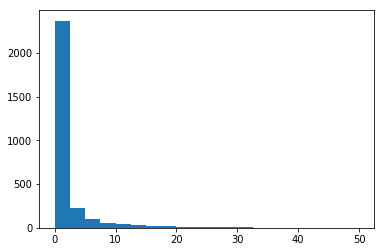

In [43]:
# Histogram of rainfall
plt.hist(all_data.rainfall, bins =20,range=(0,50)); plt.show()

Now I add in the data about each team's ladder position at the start of each match.

In [44]:
#Read in data and format it for ease-of-use

ladders = pd.read_csv('ladder_progressions.csv')

ladders.fillna(0, inplace = True)
for i in range(1, 24):
    ladders[str(i)] = ladders[str(i)].astype(int)

ladders.set_index(['Year','Team'], drop = True, inplace=True)
ladders.head()

num_rounds[2003] = 22

# Function that takes a row and home_or_away indicator and returns the corresponding ladder position 
# NOTE: for rounds 1-5, the previous season's final ladder positions are used for increased accuracy in indicating team strength

def get_position(row, home_or_away):
    
    # NOTE: Ladder positions for new teams in their first 5 matches in their inaugural year was listed as 8 to signify the 
    # fact that fans would be excited to go to their first matches
     
    if row.rnd < 6:
        return ladders.at[((int(row.year - 1)), row[home_or_away+'_team']), str(int(num_rounds[int(row.year - 1)]))]
    
    if row.rnd > 30:
        return ladders.at[(int(row.year), row[home_or_away+'_team']), str(int(num_rounds[row.year]))]
    
    return ladders.at[(int(row.year), row[home_or_away+'_team']), str(row.rnd)]

all_data['home_position'] = all_data.apply(get_position, axis = 1, args = ('home', ))
all_data['away_position'] = all_data.apply(get_position, axis = 1, args = ('away', ))

In [45]:
# All major data cleaning is now complete. Save the dataframe in a separate .csv file

all_data.to_csv('full_afl_dataset.csv', index = False)

### Feature Engineering

In [46]:
df = pd.read_csv('full_afl_dataset.csv')
df.head()

,home_team,away_team,attendance,date,stadium,rnd,year,rnd_percentage,stadium_capacity,day,local_time,timeslot,perc_filled,home_members,away_members,rainfall,home_position,away_position
0,West Coast,Collingwood,100022,2018-09-29,MCG,38,2018,100.0,100024,Saturday,14:30:00,sat_arvo,99.998000,80290,75507,0.0,2.0,3.0
1,West Coast,Melbourne,59608,2018-09-22,Perth Stadium,37,2018,100.0,60000,Saturday,13:20:00,sat_arvo,99.346667,80290,44275,0.0,2.0,5.0
2,Richmond,Collingwood,94959,2018-09-21,MCG,37,2018,100.0,100024,Friday,19:50:00,fri_night,94.936215,100726,75507,0.0,1.0,3.0
3,Collingwood,GWS Giants,72504,2018-09-15,MCG,36,2018,100.0,100024,Saturday,19:25:00,sat_night,72.486603,75507,25243,2.5,3.0,7.0
4,Hawthorn,Melbourne,90152,2018-09-14,MCG,36,2018,100.0,100024,Friday,19:50:00,fri_night,90.130369,80302,44275,0.6,4.0,5.0


In [47]:
# Add indicator variables for finals matches

df['GF'] = df.rnd == 38
df['PF'] = df.rnd == 37
df['QF/SF'] = df.rnd == 36
df['EF'] = df.rnd == 35
    
# Add in some interesting variables that I expect to be informative  (through my domain knowledge of the AFL) 
df['team_closeness'] = abs(df.home_position - df.away_position)
df['sum_of_positions'] = df.home_position+df.away_position
df['total_members'] = df['home_members'] + df['away_members']

df['western_derby'] = ((df.home_team=='West Coast') & (df.away_team=='Fremantle')) | ((df.home_team=='Fremantle') & 
                                                                                      (df.away_team == 'West Coast'))
df['adelaide_derby'] = ((df.home_team=='Adelaide') & (df.away_team=='Port Adelaide')) | ((df.home_team=='Port Adelaide') & 
                                                                                      (df.away_team == 'Adelaide'))
df['anzac_day'] = (df.date.str[5:] == '04-25') & ((df.home_team == 'Collingwood') | (df.away_team == 'Collingwood'))

#Decided not to have an Easter_Monday flag, as the games dont seem to have larger attendances than other Geel V Hawthorn games

# Add in an Australian population variable (this intuitively should be informative). 
# Data from WorldBank website (as listed in data directory)

year_to_pop = {2004: 20.13, 2005: 20.39, 2006: 20.70, 2007: 20.83, 
               2008: 21.25, 2009: 21.69, 2010: 22.03, 2011: 22.34, 
               2012: 22.73, 2013: 23.13, 2014: 23.48, 2015: 23.82, 
               2016: 24.19, 2017: 24.60, 2018: 24.99, 2019: 25.1}

df['population'] = df.apply(lambda row: year_to_pop[row.year], axis = 1)

Next, I walk through some data exploration.

In [57]:
print('Ave. perc_filled at Western Derbies: '); print(df[df.western_derby == True].perc_filled.mean())
print('\nAve. perc_filled at other Perth games: '); print(df[(df.stadium == 'Subiaco')|(df.stadium == 'Perth Stadium')].perc_filled.mean())

Ave. perc_filled at Western Derbies: 
94.64023060932901

Ave. perc_filled at other Perth games: 
84.40054953799253


The results above show that western derbies have _much_ higher perc_filled than other Freo/West Coast home games.

In [56]:
print('Ave. perc_filled at Adel. derbies: '); print(df[df.adelaide_derby == True].perc_filled.mean())
print('\nAve. perc_filled at all Adel. Oval games'); print(df[df.stadium == 'Adelaide Oval'].perc_filled.mean())

Ave. perc_filled at Adel. derbies: 
85.21215057596916

Ave. perc_filled at all Adel. Oval games
81.84708372788577


The results above show that Adelaide derbies have slightly higher perc_filled than other games at the Adelaide Oval.

In [58]:
# Taking a closer look at Adelaide derbies
df[df.adelaide_derby == True][['year','perc_filled','day']]

,year,perc_filled,day
41,2018,94.016759,Saturday
137,2018,95.117855,Saturday
237,2017,84.034115,Sunday
381,2017,100.214620,Saturday
427,2016,92.456563,Saturday
599,2016,94.348954,Saturday
683,2015,99.878693,Sunday
769,2015,92.598399,Sunday
894,2014,94.343355,Sunday
1004,2014,94.054084,Saturday


Just from taking a look at the table above, Adelaide derbies generally have strong crowds, but the numbers seem to be hurt when both teams have poor ladder positions (e.g. 2010/11). 

Next, looking into the effect of different stadiums on perc_filled. The bar chart below show lots of variation, which indicates that the stadium variable will likely be quite informative.

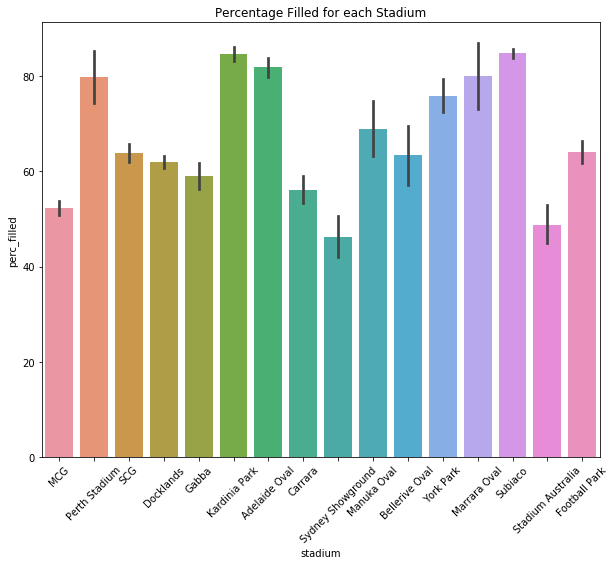

In [66]:
plt.figure(figsize=(10,8))
sns.barplot(x = 'stadium', y='perc_filled', data = df)
plt.xticks(rotation = 45); plt.title("Percentage Filled for each Stadium"); plt.show()

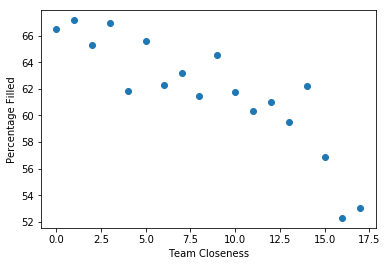

In [69]:
plt.scatter(range(18), df.groupby('team_closeness').perc_filled.agg('mean'))
plt.xlabel('Team Closeness'); plt.ylabel('Percentage Filled'); plt.show()

The plot above shows a trend that makes intuitive sense: on average, AFL matches that pit similar-strength teams against each other fill the stadium more than "unfair" match-ups (these matches would be expected to not be very interesting).

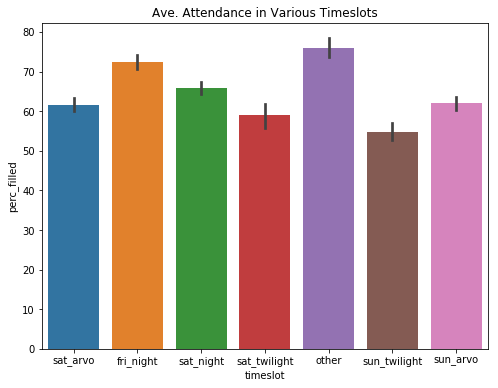

In [78]:
plt.figure(figsize=(8,6)); plt.title('Ave. Attendance in Various Timeslots')
sns.barplot(x = 'timeslot', y='perc_filled', data = df)

NOTE: the "other" timeslot seems capable of capturing the fact that special games such as Carlton V Richmond season openers (Thursday night), Queen's Birthday matches and Easter Monday matches have larger-than-normal crowds. This will be handy in the modelling stage (so that many binary variables won't be required to account for every single "special" game).

The next 2 plots show the intuitive trend that stadiums get filled more if there are more home and away team members.

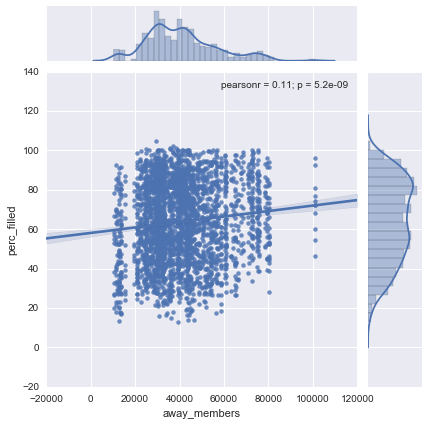

In [66]:
sns.jointplot("home_members", "perc_filled", df, kind='reg')

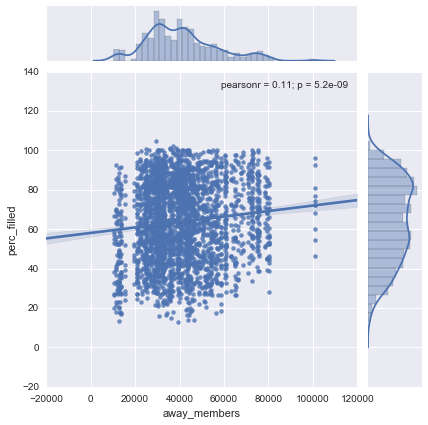

In [67]:
sns.jointplot("away_members", "perc_filled", df, kind='reg')

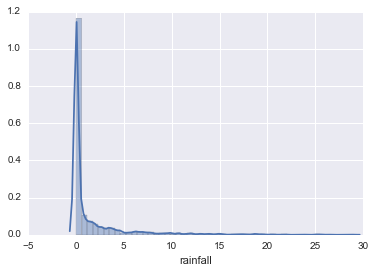

In [160]:
# Display the distribution of rainfall values (right tail not displayed)
sns.distplot(df[df.rainfall < 30].rainfall)

I decided that it would be valuable to categorise the rainfall values into categories because:
 - There are some very large values that would act as high leverage points (very influential) and cause issues in some regression models.
 - Categorisation improves model usability (users may not know exact mms of rain, but can say that it is "light" or "moderate" etc)
 - Makes model more interpretable

These are the "bins" used (numbers chosen through the 1/3 and 2/3 quantiles as shown below):
1. No (or barely noticable) rain: 0-2mm
2. Light rain: 2 - 3.6mm 
3. Moderate rain: 3.6 - 7.6 mm
4. Heavy rain: > 7.6mm

In [80]:
# Print quantiles
df[df.rainfall>=2].rainfall.quantile([0.333333, 0.666666])

0.333333    3.6
0.666666    7.6
Name: rainfall, dtype: float64

In [87]:
# Create variables for the rainfall categories (no variable required for "no rain" as it would be a redundant variable)
df['light_rain'] = (df.rainfall >= 2)&(df.rainfall < 3.6)
df['moderate_rain'] = (df.rainfall >= 3.6)&(df.rainfall <= 7.6) 
df['heavy_rain'] = (df.rainfall > 7.6)

The next cell deals with categorical variables by one-hot encoding them.

In [88]:
# One-hot encoding categorical variables

df = pd.concat([df, pd.get_dummies(df['timeslot'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['stadium'])], axis=1)

# Now drop the original 'timeslot' and 'stadium' columns (don't need them anymore)
df.drop(['timeslot','stadium'],axis=1, inplace=True)
df.head()

,home_team,away_team,attendance,date,rnd,year,rnd_percentage,stadium_capacity,day,local_time,...,Kardinia Park,MCG,Manuka Oval,Marrara Oval,Perth Stadium,SCG,Stadium Australia,Subiaco,Sydney Showground,York Park
0,West Coast,Collingwood,100022,2018-09-29,38,2018,100.0,100024,Saturday,14:30:00,...,0,1,0,0,0,0,0,0,0,0
1,West Coast,Melbourne,59608,2018-09-22,37,2018,100.0,60000,Saturday,13:20:00,...,0,0,0,0,1,0,0,0,0,0
2,Richmond,Collingwood,94959,2018-09-21,37,2018,100.0,100024,Friday,19:50:00,...,0,1,0,0,0,0,0,0,0,0
3,Collingwood,GWS Giants,72504,2018-09-15,36,2018,100.0,100024,Saturday,19:25:00,...,0,1,0,0,0,0,0,0,0,0
4,Hawthorn,Melbourne,90152,2018-09-14,36,2018,100.0,100024,Friday,19:50:00,...,0,1,0,0,0,0,0,0,0,0


In [7]:
# Remove variables that are no longer needed for modelling purposes

df.drop(['home_team','away_team','attendance','date','rnd','year','stadium_capacity','day','local_time',
        'rainfall'], axis = 1, inplace=True)
df.head()

,rnd_percentage,perc_filled,home_members,away_members,home_position,away_position,GF,PF,QF/SF,EF,...,Kardinia Park,MCG,Manuka Oval,Marrara Oval,Perth Stadium,SCG,Stadium Australia,Subiaco,Sydney Showground,York Park
0,100.0,99.998000,80290,75507,2.0,3.0,True,False,False,False,...,0,1,0,0,0,0,0,0,0,0
1,100.0,99.346667,80290,44275,2.0,5.0,False,True,False,False,...,0,0,0,0,1,0,0,0,0,0
2,100.0,94.936215,100726,75507,1.0,3.0,False,True,False,False,...,0,1,0,0,0,0,0,0,0,0
3,100.0,72.486603,75507,25243,3.0,7.0,False,False,True,False,...,0,1,0,0,0,0,0,0,0,0
4,100.0,90.130369,80302,44275,4.0,5.0,False,False,True,False,...,0,1,0,0,0,0,0,0,0,0


## ML Model Building


**Approach:**

1. Start by building a decision tree regressor and linear regression models to gain a basic understanding

2. Use feature selection methods such as Lasso Regression and forward subset selection for linear regression
    - Use cross-validation to choose regularisation coefficent
    
    
3. Use k-Nearest Neighbours regression (will have to use dimensionality reduction to avoid issues with the Curse of Dimensionality)
4. Use ensemble methods such as Random Forests
    - Tune hyperparameters such as _number of trees_ using grid-search cross validation
    
    
5. Evaluate all models using cross-validation to avoid overfitting
6. Select best model, taking into account performance and interpretability for end-user.

In [89]:
# Load required libraries
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import graphviz
import pydotplus
from IPython.display import Image  

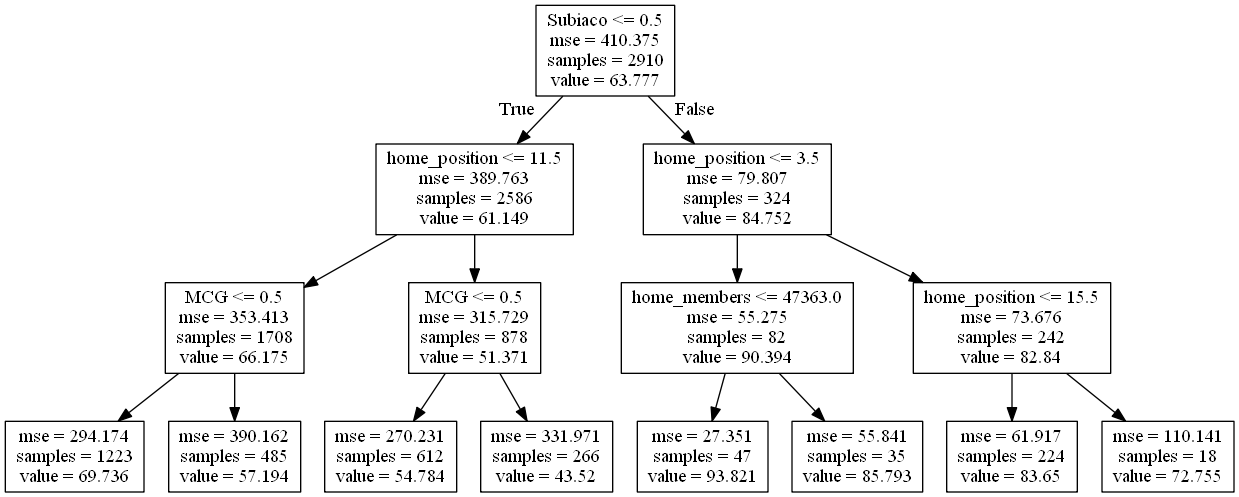

<Figure size 432x288 with 0 Axes>

In [92]:
# Fit a simple regression (tree depth = 3 for illustration purposes)

rt=DecisionTreeRegressor(max_depth = 3)
rt.fit(df[['home_members','home_position','GF','PF','EF','QF/SF',
            'MCG','Perth Stadium','Subiaco','York Park','Manuka Oval',
            'Kardinia Park']], df.perc_filled)

columns=['home_members','home_position','GF','PF','EF','QF/SF',
            'MCG','Perth Stadium','Subiaco','York Park','Manuka Oval',
            'Kardinia Park']
dot_data = tree.export_graphviz(rt,out_file=None,feature_names=columns)

# Create tree diagram
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show diagram
plt.figure()
Image(graph.create_png())